# XGB + CV

In [5]:
import matplotlib.pyplot as plt
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
import numpy as np
import pandas as pd
import os
from collections import Counter 

from sklearn.neighbors import KNeighborsClassifier  ## KNN
from sklearn.linear_model import LogisticRegressionCV  ## logistic regression
from sklearn.tree import DecisionTreeClassifier  ## decision tree
from sklearn.svm import SVC  ## SVM

from sklearn.tree import DecisionTreeClassifier  ## decision tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

import math
import string
import re

import xgboost

from preprocess import preprocess
plt.rcParams['figure.figsize'] = [10, 8]

# 鐵達尼號資料集

In [6]:
df = pd.read_csv('train.csv')
df = preprocess(df)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Cabin,Embarked,Has_Cabin,Age_Cat,Fare_log2,Fare_Cat,Name_Length,Name_With_Special_Char,Family_Size,Title
0,1,0,3,1,22.0,1,0,2,0,0,0,1,2.857981,0,23,0,1,1
1,2,1,1,0,38.0,1,0,5,3,2,1,2,6.155492,5,51,1,1,3
2,3,1,3,0,26.0,0,0,7,0,0,0,1,2.986411,0,22,0,0,2
3,4,1,1,0,35.0,1,0,1,3,0,1,2,5.730640,4,44,1,1,3
4,5,0,3,1,35.0,0,0,1,0,0,0,2,3.008989,0,24,0,0,1


In [7]:
X = df[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Cabin', 'Embarked', 'Has_Cabin', 'Age_Cat', 'Fare_log2',
       'Fare_Cat', 'Name_Length', 'Name_With_Special_Char', 'Family_Size',
       'Title']].values
Y = df['Survived'].values

In [8]:
from sklearn.model_selection  import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size =0.3, random_state=1212)  ## 一般如果測試資料集超過1000筆就可以了，所以比率不會設這麼高
print(X_train.shape)  ## (445, 17)
print(X_valid.shape)  ## (446, 17) 
print(Y_train.shape)  ## (445,)
print(Y_valid.shape)  ## (446,)

(623, 17)
(268, 17)
(623,)
(268,)


In [9]:
def get_accuracy(clf):
    #=============your works starts===============#
    clf = clf()
    clf =  clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_valid)
    accuracy = (str(sum(Y_valid == y_pred)/Y_valid.shape[0]))
    #==============your works ends================#
    return accuracy

print('SVM: ', get_accuracy(SVC))
print('DecisionTree: ', get_accuracy(DecisionTreeClassifier))
print('RandomForest: ', get_accuracy(RandomForestClassifier))
print('AdaBoost: ', get_accuracy(AdaBoostClassifier))  ## Boosting的演算法
print('XGB: ', get_accuracy(XGBClassifier))

# SVM:  0.609865470852
# DecisionTree:  0.764573991031
# RandomForest:  0.795964125561
# AdaBoost:  0.784753363229
# XGB:  0.80269058296

SVM:  0.6455223880597015
DecisionTree:  0.746268656716418
RandomForest:  0.835820895522388
AdaBoost:  0.7910447761194029


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


XGB:  0.8432835820895522


In [10]:
# Set our parameters for xgboost
params = {}
# 請填入以下參數: 
# 目標函數: 二元分類
# 評價函數: logloss
# 學習速度: 0.04
# 最大深度: 5
#=============your works starts===============#
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.04
params['max_depth'] = 3
#==============your works ends================#

d_train = xgboost.DMatrix(X_train, label=Y_train)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgboost.train(params, d_train, 100, watchlist, early_stopping_rounds=100, verbose_eval=0)
y_pred = bst.predict(xgboost.DMatrix(X_valid))
print("Accuracy: ", str(sum(Y_valid == (y_pred > 0.5))/Y_valid.shape[0]))


[16:37:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:37:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:37:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:37:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:37:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:37:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:37:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

# 空氣品質

In [11]:
# dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y %H:%M:%S')
# dateparse_1 = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
# EPA_6 = pd.read_csv('air_pollution_data/EPA_OD_201806.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_7 = pd.read_csv('air_pollution_data/EPA_OD_201807.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_8 = pd.read_csv('air_pollution_data/EPA_OD_201808.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_9 = pd.read_csv('air_pollution_data/EPA_OD_201809.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_10 = pd.read_csv('air_pollution_data/EPA_OD_201810.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_11 = pd.read_csv('air_pollution_data/EPA_OD_201811.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_12 = pd.read_csv('air_pollution_data/EPA_OD_201812.csv', parse_dates=['PublishTime'], date_parser=dateparse_1)
# frames = [EPA_6, EPA_7, EPA_8, EPA_9, EPA_10, EPA_11, EPA_12]
# df_AQI = pd.concat(frames)
# df_AQI.to_pickle('air_pollution_data.pkl')
# df_AQI.head()

In [12]:
# df_AQI = pd.read_pickle('air_pollution_data.pkl')
# df_AQI.sort_values(by='PublishTime', inplace=True)
# df_AQI = df_AQI.loc[df_AQI['SiteName'] == '麥寮', ['SiteName', 'AQI', 'PM2.5', 'SO2', 'PublishTime']]
# df_AQI.to_pickle('df_AQI_gl.pkl')

In [13]:
df_AQI = pd.read_pickle('df_AQI_gl.pkl')

In [14]:
window = 7
shift = 1
segments = int((df_AQI.shape[0] - window) // shift) + 1

train = np.zeros((segments-1, 2 * window))
target = np.zeros((segments-1,))
for segment in range(segments -1):
    seg = df_AQI.iloc[segment:segment+window][['SO2', 'PM2.5']]
    target[segment] = df_AQI.iloc[segment+window][['AQI']]
    train[segment] = np.append(seg['SO2'].values, seg['PM2.5'].values)

In [15]:
train = np.where(np.isnan(train), -1, train)
target = np.where(np.isnan(target), int(np.nanmean(target)), target)

In [16]:
train.shape, target.shape

((4721, 14), (4721,))

In [17]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train, target, test_size=0.2, random_state=2019)
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((3776, 14), (3776,), (945, 14), (945,))

In [18]:
# Set our parameters for xgboost
params = {}

# 請填入以下參數: 
# 目標函數: 線性回歸
# 評價函數: rmse
# 學習速度: 0.01
# 最大深度: 5
# bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=50, verbose_eval=10)
#=============your works starts===============#
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['eta'] = 0.03
params['max_depth'] = 3
d_train = xgboost.DMatrix(X_train, label=Y_train)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=10, verbose_eval=10)
Y_pred = bst.predict(xgboost.DMatrix(X_valid))
#==============your works ends================#


[16:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:74.7182	valid-rmse:75.092
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[16:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\

[16:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[170]	train-rmse:12.711	valid-rmse:18.8637
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\s

[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[220]	train-rmse:12.4095	valid-rmse:18.803
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\s

[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[280]	train-rmse:12.1038	valid-rmse:18.7303
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:38:02] C:\Users\Administrator\Desktop\xgboost\

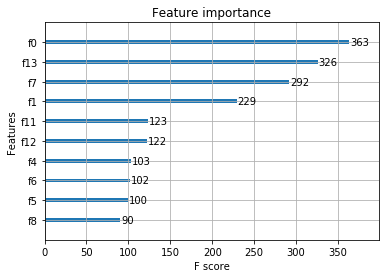

In [19]:
# 請使用 xgboost.plot_importance，並設定max_num_features=10
#!=============your works starts===============!#
xgboost.plot_importance(bst, max_num_features=10)
#!==============your works ends================!#

plt.show()

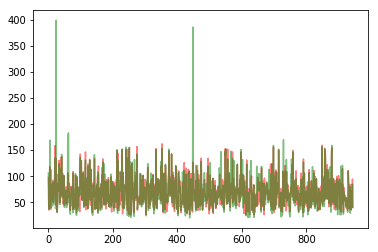

In [20]:
plt.plot(Y_pred, label='Y_pred', alpha=0.5, c='r')
plt.plot(Y_valid, label='Y_valid', alpha=0.5, c='g')
plt.show()

In [21]:
df_result = pd.DataFrame()

# 1. 使用X_valid去評價此模型
# 2. 使用 ['predict', 'truth', 'error'] 三個欄位的DataFrame去使決畫呈現預測結果
#    (1). 請注意與測結果(Y_pred)與真實值(Y_valid)都必須取exp方能反映實際情況
#    (2). error 請使用計算np.abs(predict-truth)/truth計算誤差百分比
#=============your works starts===============#
Y_pred = bst.predict(xgboost.DMatrix(X_valid))
df_result['predict'] = Y_pred
df_result['truth'] = (list(Y_valid))
df_result['error'] = df_result.apply(lambda x:np.abs(x['predict'] - x['truth']) / x['truth'], axis=1)
df_result_sort = df_result.sort_values('truth')
#==============your works ends================#

df_result.head()

,predict,truth,error
0,97.562889,106.0,0.079595
1,48.304008,37.0,0.305514
2,34.956127,37.0,0.055240
3,59.692013,67.0,0.109074
4,118.139969,116.0,0.018448


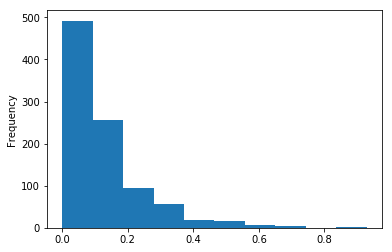

In [22]:
# 請使用df_result_sort濾掉error大於1的部分畫出error的分布圖
#!=============your works starts===============!#
df_result_sort.loc[df_result_sort['error'] < 1, 'error'].plot('hist')
#!==============your works ends================!#

plt.show()

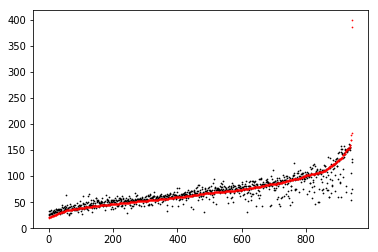

In [23]:
# 請使用plt.scatter，以0~len(df_result)作為x，預測值(黑色)與實際值(紅色)作為y。
#!=============your works starts===============!#
plt.scatter(range(len(df_result)), df_result_sort['predict'].values, color='black', s=0.5)
plt.scatter(range(len(df_result)), df_result_sort['truth'].values, color='red', s=0.5)
#!==============your works ends================!#

plt.show()

# 房價資料集

In [24]:
# import urllib.request
# if 'df_realestate_processed.csv' not in os.listdir():
#     url = 'https://s3.amazonaws.com/datasets-jeremy/df_realestate_processed.csv'  
#     urllib.request.urlretrieve(url, 'df_realestate_processed.csv')
    
# # processed
# path = "df_realestate_processed.csv"
# df_realestate_processed = pd.read_csv(path)
# X = df_realestate_processed.drop(["price_per_meter", "total_price"], axis=1)
# Y = df_realestate_processed['total_price']


In [25]:
# X_train = X.iloc[:-1000]
# Y_train = Y.iloc[:-1000]
# Y_train = np.log(Y_train) 

# X_valid = X.iloc[-1000:]
# Y_valid = Y.iloc[-1000:]
# Y_valid = np.log(Y_valid) 

In [26]:
# # Set our parameters for xgboost
# params = {}

# # 請填入以下參數: 
# # 目標函數: 線性回歸
# # 評價函數: rmse
# # 學習速度: 0.01
# # 最大深度: 5
# # bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=50, verbose_eval=10)
# #=============your works starts===============#
# params['objective'] = 'reg:linear'
# params['eval_metric'] = 'rmse'
# params['eta'] = 0.03
# params['max_depth'] = 3
# d_train = xgboost.DMatrix(X_train, label=Y_train)
# d_valid = xgboost.DMatrix(X_valid, label=Y_valid)
# watchlist = [(d_train, 'train'), (d_valid, 'valid')]
# bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=10, verbose_eval=10)
# Y_pred = bst.predict(xgboost.DMatrix(X_valid))
# #==============your works ends================#


In [27]:
#　模型save與load的方式自己看
# bst.save_model("bst_subtotal_log_with_cross.pickle.dat")
# bst = xgboost.Booster({'nthread':1}) #init model
# bst.load_model("bst_subtotal_log_with_cross.pickle.dat") # load data


In [28]:
# # 請使用 xgboost.plot_importance，並設定max_num_features=10
# #!=============your works starts===============!#
# xgboost.plot_importance(bst, max_num_features=10)
# #!==============your works ends================!#

# plt.show()

In [29]:
# df_result = pd.DataFrame()

# # 1. 使用X_valid去評價此模型
# # 2. 使用 ['predict', 'truth', 'error'] 三個欄位的DataFrame去使決畫呈現預測結果
# #    (1). 請注意與測結果(Y_pred)與真實值(Y_valid)都必須取exp方能反映實際情況
# #    (2). error 請使用計算np.abs(predict-truth)/truth計算誤差百分比
# #=============your works starts===============#
# Y_pred = bst.predict(xgboost.DMatrix(X_valid))
# df_result['predict'] = np.exp(Y_pred)
# df_result['truth'] = np.exp((list(Y_valid)))
# df_result['error'] = df_result.apply(lambda x:np.abs(x['predict'] - x['truth']) / x['truth'], axis=1)
# df_result_sort = df_result.sort_values('truth')
# #==============your works ends================#

# df_result.head()

In [30]:
# # 請使用df_result_sort濾掉error大於1的部分畫出error的分布圖
# #!=============your works starts===============!#
# df_result_sort.loc[df_result_sort['error'] < 1, 'error'].plot('hist')
# #!==============your works ends================!#

# plt.show()

In [31]:
# # 請使用plt.scatter，以0~len(df_result)作為x，預測值(黑色)與實際值(紅色)作為y。
# #!=============your works starts===============!#
# plt.scatter(range(len(df_result)), df_result_sort['predict'].values, color='black', s=0.5)
# plt.scatter(range(len(df_result)), df_result_sort['truth'].values, color='red', s=0.5)
# #!==============your works ends================!#

# plt.show()